## Import Dependencies and Data:

In [12]:
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Loading the dataset
dataset = tfds.load("fashion_mnist", split = 'train')

# setting the dataset as numpy iterator so that we get batches of data
dataset_iter = dataset.as_numpy_iterator()
batch = dataset_iter.next()
batch.keys()

dict_keys(['image', 'label'])

In [3]:
batch['image'].shape

(28, 28, 1)

In [4]:
batch['label'].shape

()

In [5]:
batch

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

In [6]:
# removing that extra channel
batch['image'].squeeze().shape

(28, 28)

## Plotting the Images for Visualization:

In [7]:
rand_img = np.random.rand(28, 28, 3)
rand_img.shape

(28, 28, 3)

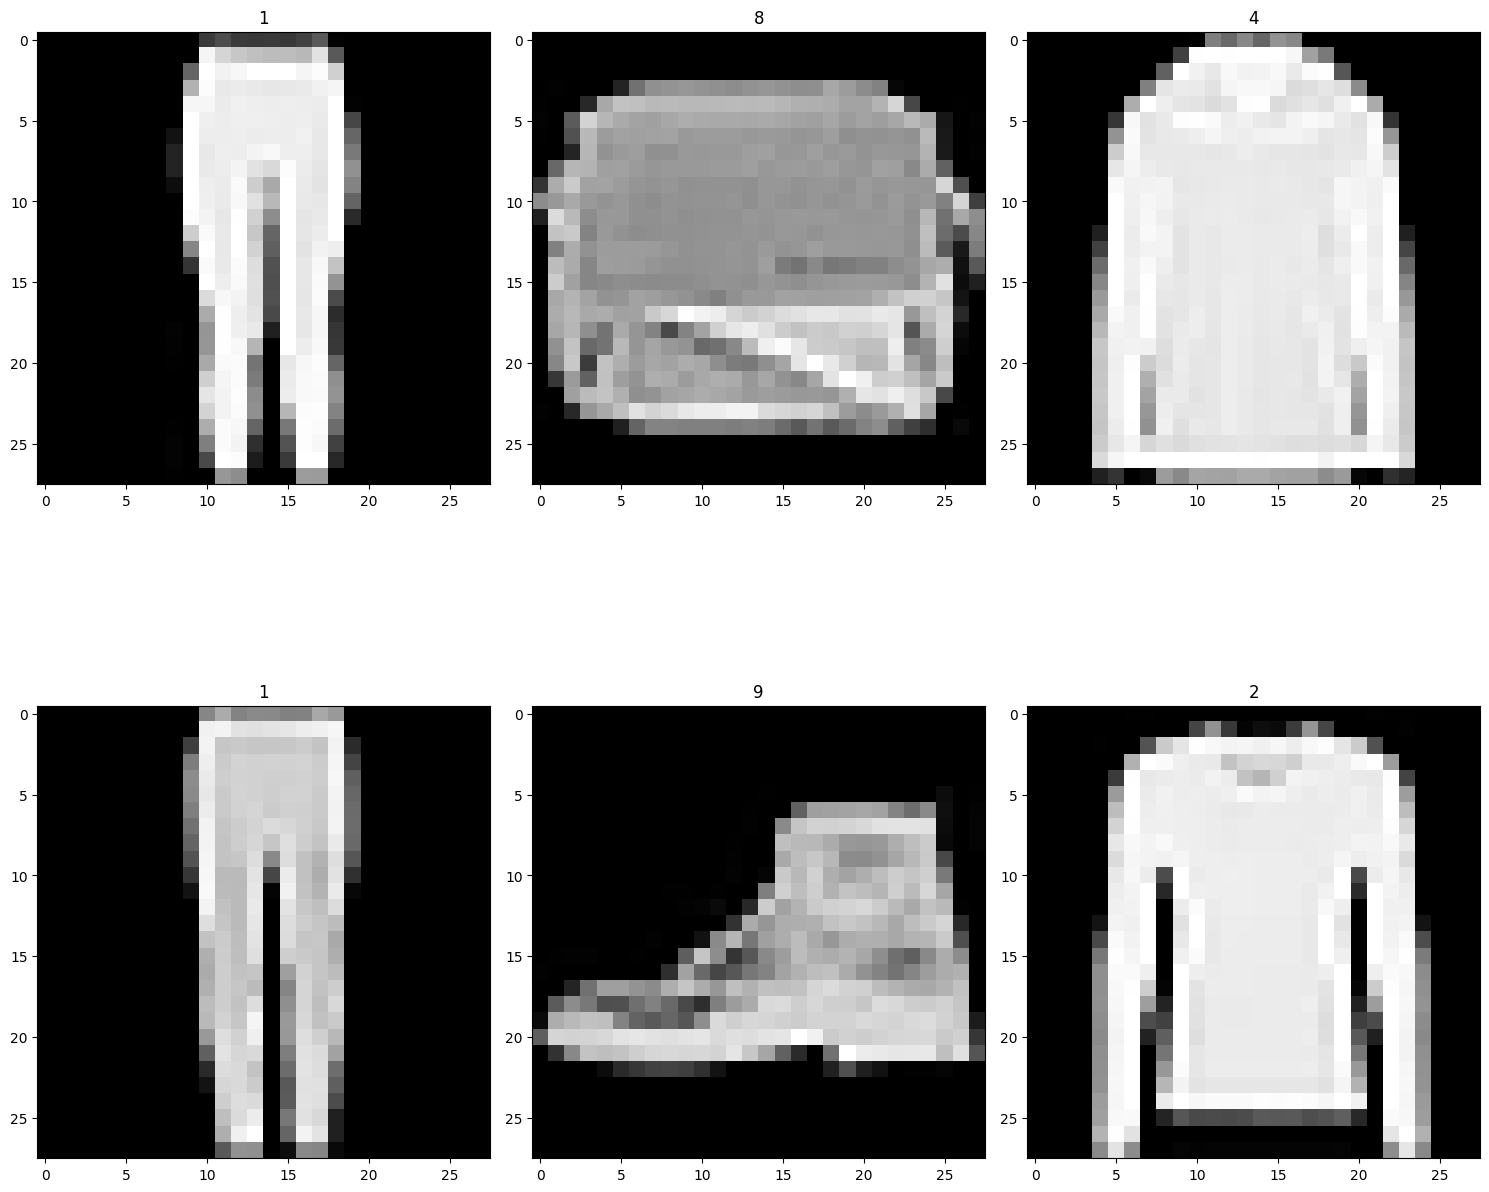

In [8]:
ncols = 3
nrows = 2
fig, axis = plt.subplots(ncols = ncols, nrows = nrows, figsize = (15, 15))

axis = axis.flatten()

for img in range(ncols * nrows):
    batch = dataset_iter.next() # different image and label(batch) for each sublot
    axis[img].imshow(batch['image'].squeeze(), cmap = 'gray')
    axis[img].title.set_text(batch['label'])

plt.tight_layout()
plt.show()

## Data Pipelining:

In [9]:
# function to normalize the value between 0 and 255 to between 0 and 1
def scale_images(data):
    image = data['image']

    return image/255

In [10]:
# reloading the dataset for pipelining
dataset = tfds.load('fashion_mnist', split = 'train')

# mapping the scale function to each element in the dataset
dataset = dataset.map(scale_images)

# caching the dataset to memory for faster loading time
dataset = dataset.cache()

# shuffling the data of 60000 images and labels
dataset = dataset.shuffle(60000)

# batching the data into 128 images per batch
batch_size = 128
dataset = dataset.batch(batch_size)

# prefetching 64 batches in advance to avoid bottlenecking
dataset = dataset.prefetch(64)

# setting input dimension
latent_dim = 128

In [11]:
# checking if the preprocessing worked
dataset.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Building the Neural Network:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### Building Generator: 

In [5]:
def build_generator():
    model = Sequential([

        Dense(7 * 7 * 128, input_dim = latent_dim), # takes in random values of size 128
        LeakyReLU(0.2), # to prevent dying neurons
        Reshape((7, 7, 128)), # Reshaping the image to shape: 7x7x128

        UpSampling2D(), # upsampling the image to 14x14x128 for higher resolution
        Conv2D(128, (5, 5), padding = 'same'), # convolutional network to learn 128 features across the image
        LeakyReLU(0.2), # activation function to prevent dying neurons

        UpSampling2D(), # upsampling the image to 28x28x128 for higher resolution
        Conv2D(128, (5, 5), padding = 'same'), # convolutional network to learn 128 features across the image
        LeakyReLU(0.2), # activation function to prevent dying neurons

        Conv2D(128, (4, 4), padding = 'same'), # convolutional network to learn 256 features across the image
        LeakyReLU(0.2), # activation function to prevent dying neurons

        Conv2D(128, (4, 4), padding = 'same'), # convolutional network to learn 128 features across the image
        LeakyReLU(0.2), # activation function to prevent dying neurons

        Conv2D(1, (4, 4), padding = 'same', activation = 'sigmoid') # final output layer which outputs 28, 28, 1 shaped images
        
    ])

    return model

In [7]:
latent_dim = 128
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [15]:
image = generator.predict(np.random.rand(6, 128, 1))
image.shape

1/1 [==============================] - 5s 5s/step


(6, 28, 28, 1)

In [16]:
image.squeeze().shape

(6, 28, 28)

### Visualizing the Generated Images:

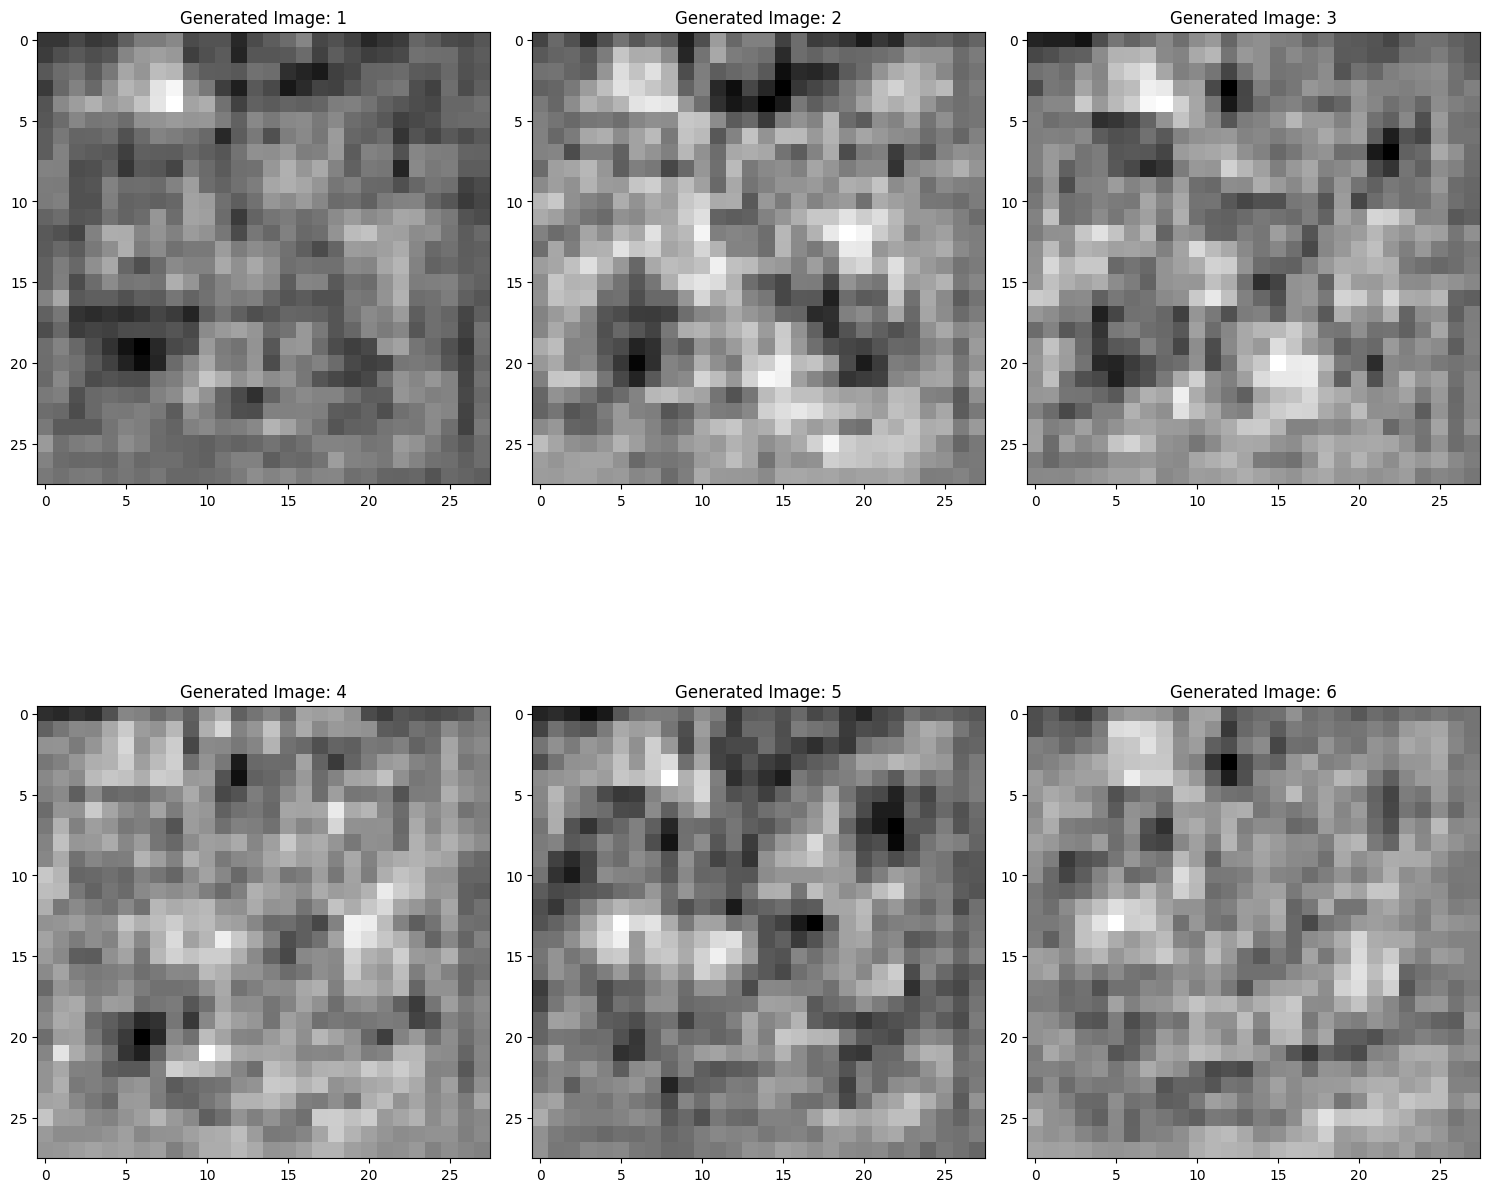

In [17]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 15))

ax = ax.flatten()

for id, img in enumerate(image):
    ax[id].imshow(image[id].squeeze(), cmap='gray')
    ax[id].set_title(f"Generated Image: {id + 1}")

plt.tight_layout()
plt.show()

### Building Discriminator:

In [15]:
def build_discriminator():
    model = Sequential([

        Conv2D(32, (5, 5), input_shape = (28, 28, 1)), # convolutional network to learn 32 features across the image also the input layer
        LeakyReLU(0.2), # Activation function to prevent dying neurons
        Dropout(0.4), # randomly turns of 40% neurons during training to prevent overfitting

        Conv2D(64, (5, 5)), # convolutional network to learn 64 features across the image(more patterns)
        LeakyReLU(0.2), # Activation function to prevent dying neurons
        Dropout(0.4), # randomly turns of 40% neurons during training to prevent overfitting

        Conv2D(128, (5, 5)), # convolutional network to learn 128 features across the image(much more patterns)
        LeakyReLU(0.2), # Activation function to prevent dying neurons
        Dropout(0.4), # randomly turns of 40% neurons during training to prevent overfitting

        Conv2D(256, (5, 5)), # convolutional network to learn 256 features across the image(much much more patterns)
        LeakyReLU(0.2), # Activation function to prevent dying neurons
        Dropout(0.4), # randomly turns of 40% neurons during training to prevent overfitting

        Flatten(), # flattens the output from 2D to 1D
        Dropout(0.4), # randomly turns of 40% neurons during training to prevent overfitting
        Dense(1, activation = 'sigmoid') # final output layer to judge the generator
        
    ])

    return model

In [16]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [20]:
image.shape

(6, 28, 28, 1)

In [21]:
discriminator.predict(image)

1/1 [==============================] - 0s 240ms/step


array([[0.4996444 ],
       [0.49963644],
       [0.49955153],
       [0.49967173],
       [0.49971038],
       [0.49961382]], dtype=float32)

## Construct Custom Training Loop:

In [22]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
# setting the learning rates of generator and optimizer
gen_optimizer = Adam(learning_rate = 0.0001) # the learning rate is a little higher cause it is naturally weaker
dis_optimizer = Adam(learning_rate = 0.00001) # the learning rate is a little lower cause it is naturally stronger

# setting the loss for the generator and discriminator
gen_loss = BinaryCrossentropy()
dis_loss = BinaryCrossentropy()

In [24]:
# custom training class inheriting from tensorflow -> keras -> Model class
class Fashion_GAN(tf.keras.Model):


    # constructor to initialize the generator, discriminator, and latent_dim
    def __init__(self, generator, discriminator, latent_dim, batch_size, *args, **kwargs):

        # calling the parent class constructor to initialize properly (calling the constructor engine)
        super().__init__(*args, **kwargs)

        # create attributes for generator and discriminator latent dimension and batch_size
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.batch_size = batch_size

    # prepares the model for training like standard .compile() method
    def compile(self, gen_optimizer, dis_optimizer, gen_loss, dis_loss, *args, **kwargs):

        # compile with base class (calling the compile engine)
        super().compile(*args, **kwargs)

        # set attributes for generator and discriminator optimizer and loss
        self.gen_optimizer = gen_optimizer
        self.dis_optimizer = dis_optimizer
        self.gen_loss = gen_loss
        self.dis_loss = dis_loss

    # define a custom training step for our GAN
    def train_step(self, batch):

        # creating a random noise tensor for generator to predict
        tensor = tf.random.normal((self.batch_size, self.latent_dim))

        # setting the data for real_images and fake_images
        real_images = batch
        # creating fake_images with generator to fool our discriminator also these images will not train the generator model
        fake_images = self.generator(tensor, training = False)

        # TRAIN the DISCRIMINATOR:
        
        # this GradientTape() opens a recording notebook like Tape so tensorflow can track operations and compute gradients for discriminator
        with tf.GradientTape() as discriminator_tape:

            # passing real and fake images through the discriminator
            yhat_real = self.discriminator(real_images, training = True)
            yhat_fake = self.discriminator(fake_images, training = True)

            # combine both into one big list
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis = 0)
            # create the labels for them 0 for real images and 1 for fake images
            y_labels_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis = 0)

            # adding noise to the TRUE outputs which helps in stable training and prevents the discriminator from becoming overcondfident
            noise_real = 0.5 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.5 * tf.random.uniform(tf.shape(yhat_fake))

            # adding the noise to the labels so they are slightly off the perfect 0 and 1
            y_labels_realfake += tf.concat([noise_real, noise_fake], axis = 0)

            # calculate the total discriminator loss by seeing what it actually was and what the discriminator predicted
            total_dis_loss = self.dis_loss(y_labels_realfake, yhat_realfake)

        # calculate the gradient in how much each weight the discriminator should change
        # (trainable_variables is a list of all the parameters in the model that can be trained via back propagation)
        dis_gradient = discriminator_tape.gradient(total_dis_loss, self.discriminator.trainable_variables)
        # applying the changes to the model using backpropagation using optimizer (in this case Adam)
        self.dis_optimizer.apply_gradients(zip(dis_gradient, self.discriminator.trainable_variables))

        # TRAIN the GENERATOR:

        with tf.GradientTape() as generator_tape:
            
            # create fake images for the discriminator to judge
            generated_images = self.generator(tensor, training = True)

            # judging the generated images with discriminator but not training here
            predicted_labels = self.discriminator(generated_images, training = False)

            # calculate the total generator loss by seeing what was predicted by the discriminator and real label
            total_gen_loss = self.gen_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # calculate the gradient in how much each weight the generator should change
        # (trainable_variables is a list of all the parameters in the model that can be trained via back propagation)
        gen_gradient = generator_tape.gradient(total_gen_loss, self.generator.trainable_variables)
        # applying the changes to the model using backpropagation using optimizer (in this case Adam)
        self.gen_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"gen_loss": total_gen_loss, "dis_loss": total_dis_loss}

In [25]:
batch_size

128

In [26]:
latent_dim

128

In [27]:
# creating an instance of that object
fashgan_model = Fashion_GAN(generator, discriminator, batch_size, latent_dim)

# compile the model
fashgan_model.compile(gen_optimizer, dis_optimizer, gen_loss, dis_loss)

In [28]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [29]:
# creating custom callback function by inheriting from tensorflow -> keras -> Callback class
# main purpose is to save the images which the generator is generating to see what your model is learning as it trains
class custom_model_monitor(Callback):

    
    # Constructor to initialize number of images and random noise dimension for the generator input
    def __init__(self, num_img = 3, latent_dim = 128):

        # create attributes for number of images to be saved and the random noise for the genrator to generate
        self.num_img = num_img
        self.latent_dim = latent_dim

    # This function is called every epoch ending to generate images by the generator
    def on_epoch_end(self, epoch, logs = None):

        # save every 10 epochs
        if epoch % 10 != 0:
            return

        # generate a random tensor of number of img x dimension/noise for the generator to generate an img
        random_tensor = tf.random.normal((self.num_img, self.latent_dim, 1))
        # generate num_img number of random images to save for later viewing
        generated_images = self.model.generator(random_tensor)
        # scale the images from 0-1 to 0-225
        generated_images *= 255
        # conver the image to numpy array for better saving
        # generated_images.numpy()

        # save the images
        for i in range(self.num_img):
            # converting the numpy array to PIL image object
            img = array_to_img(generated_images[i])
            # saving in the directory images as png for lossless compression
            img.save(os.path.join('images', f'generated_image_{epoch}_{i}.png'))

In [30]:
for batch in dataset.take(1):
    print("Sample batch shape:", tf.shape(batch).numpy())

Sample batch shape: [128  28  28   1]


## Training the model:

In [31]:
hist = fashgan_model.fit(dataset, epochs = 175, callbacks = [custom_model_monitor()])

Epoch 1/175
  6/469 [..............................] - ETA: 2:57 - gen_loss: 0.6898 - dis_loss: 0.6947

469/469 [==============================] - 186s 382ms/step - gen_loss: 0.7520 - dis_loss: 0.6424
Epoch 2/175
469/469 [==============================] - 180s 383ms/step - gen_loss: 1.2957 - dis_loss: 0.5917
Epoch 3/175
469/469 [==============================] - 180s 383ms/step - gen_loss: 1.4314 - dis_loss: 0.5680
Epoch 4/175
469/469 [==============================] - 180s 383ms/step - gen_loss: 1.4584 - dis_loss: 0.5656
Epoch 5/175
469/469 [==============================] - 180s 383ms/step - gen_loss: 1.4623 - dis_loss: 0.5654
Epoch 6/175
469/469 [==============================] - 180s 383ms/step - gen_loss: 1.4585 - dis_loss: 0.5656
Epoch 7/175
469/469 [==============================] - 180s 383ms/step - gen_loss: 1.4611 - dis_loss: 0.5654
Epoch 8/175
469/469 [==============================] - 180s 383ms/step - gen_loss: 1.4718 - dis_loss: 0.5627
Epoch 9/175
469/469 [==============================] - 180s 383ms/step - gen_loss: 1.4621 - dis_loss: 0.5638
Epoch 10/175
469/469 [=========

In [35]:
hist.history

{'gen_loss': [0.9143166542053223,
  1.410400390625,
  1.4371922016143799,
  1.4446399211883545,
  1.4754259586334229,
  1.434504747390747,
  1.4481515884399414,
  1.4797797203063965,
  1.4749023914337158,
  1.490952491760254,
  1.4453535079956055,
  1.4861679077148438,
  1.5100021362304688,
  1.4923467636108398,
  1.5236599445343018,
  1.4969098567962646,
  1.5240659713745117,
  1.4691451787948608,
  1.4910504817962646,
  1.4819016456604004,
  1.509178638458252,
  1.4635026454925537,
  1.495140552520752,
  1.5211985111236572,
  1.4810693264007568,
  1.533217430114746,
  1.5203535556793213,
  1.495851993560791,
  1.4775550365447998,
  1.4887502193450928,
  1.533259630203247,
  1.5696730613708496,
  1.396606206893921,
  1.2162353992462158,
  1.1791174411773682,
  1.1624736785888672,
  1.042881727218628,
  0.9966665506362915,
  1.0568864345550537,
  1.0429210662841797,
  1.0477428436279297,
  0.40057167410850525,
  0.234558567404747,
  0.18129949271678925,
  0.18136468529701233,
  0.17929

## Metrics Evaluation:

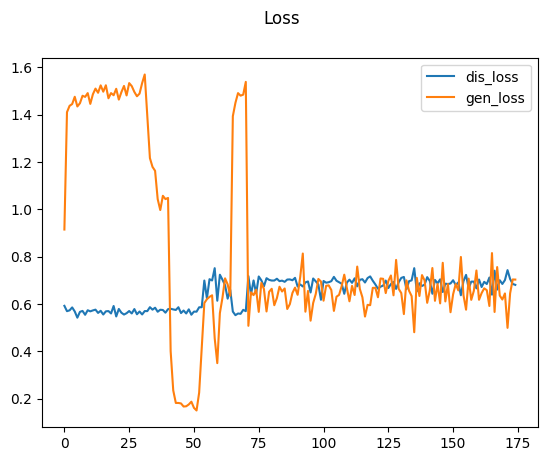

In [36]:
plt.suptitle('Loss')
plt.plot(hist.history['dis_loss'], label='dis_loss')
plt.plot(hist.history['gen_loss'], label='gen_loss')
plt.legend()
plt.show()

## Save the models:

In [37]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

## Load the models:

In [1]:
import tensorflow as tf

In [8]:
generator.load_weights('generator.h5')

In [17]:
discriminator.load_weights('discriminator.h5')

## Testing the model:

In [18]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 39ms/step


In [19]:
imgs

array([[[[1.03218668e-18],
         [1.15664344e-24],
         [2.08705375e-20],
         ...,
         [3.26238654e-11],
         [1.88482474e-07],
         [2.50942503e-06]],

        [[6.01957732e-23],
         [6.54079964e-30],
         [1.43250169e-27],
         ...,
         [1.75377237e-12],
         [5.79120696e-10],
         [1.04397165e-10]],

        [[7.11350169e-29],
         [5.66465994e-27],
         [2.28915444e-22],
         ...,
         [1.42956957e-09],
         [1.70845482e-07],
         [1.76209127e-08]],

        ...,

        [[1.14982413e-06],
         [2.67822458e-07],
         [3.37257188e-06],
         ...,
         [4.62116586e-04],
         [1.67950371e-03],
         [1.77753940e-02]],

        [[6.38519530e-04],
         [6.55634067e-05],
         [3.97304393e-05],
         ...,
         [3.11545155e-05],
         [5.03140385e-04],
         [3.18345167e-02]],

        [[5.45619754e-04],
         [1.07876122e-05],
         [8.92045773e-06],
         ...,
 

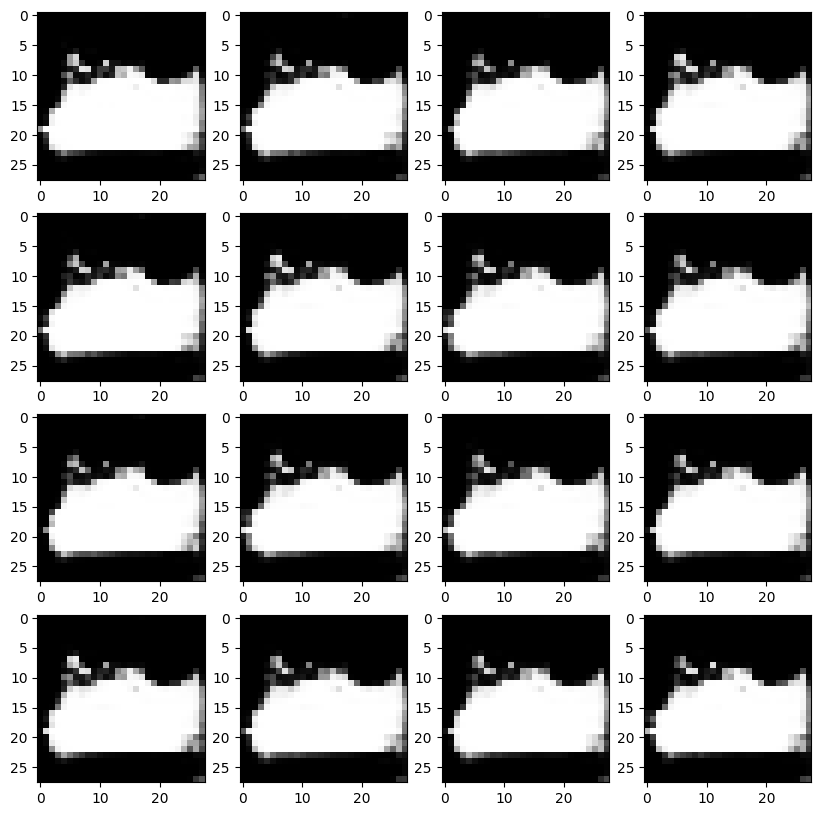

In [24]:
# very bad images beacuse of very less epochs suggested upto 2000 can go higher if you want
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1], cmap = 'grey')

In [23]:
discriminator.predict(imgs)

1/1 [==============================] - 0s 34ms/step


array([[0.50476295],
       [0.50407994],
       [0.50500005],
       [0.5045342 ],
       [0.503626  ],
       [0.50309163],
       [0.5041845 ],
       [0.5044554 ],
       [0.50397676],
       [0.5035956 ],
       [0.5047331 ],
       [0.5039697 ],
       [0.50540763],
       [0.50379646],
       [0.5038358 ],
       [0.5027486 ]], dtype=float32)